# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import json

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cmx 
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import LocalOutlierFactor

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn import preprocessing
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset


In [2]:
# connect to my google drive to work in colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Change working directory and load my libraries
os.chdir('/content/drive/MyDrive/Colab_Notebooks/flow_class_vir')

from flow_class_vir import Plot_color_map 
from flow_class_vir import data_cleaning
from flow_class_vir import Autoencoder


# Q1.
 **Read the attached paper. How do you think the paper would be relevant to the flow classification problem?**

## Summary of the paper

In the paper Desmet2017, the pressure of a machine's air accumulator is measured over time. The pressure has two main components: the accumulator charging and discharging cycles and, on top of that, pressure drops corresponding to the activation of different components. The paper focuses on the activation of two different greasy sprays. 

First, they perform a wavelet transformation to decompose the pressure measurements into different frequencies. Then, they use these wavelets to train a random forest algorithm that classifies them into one of three categories:

*   Inactive
*   Upper greasy spray activated or
*   Lower greasy spray activated.


Their idea is that if for example, the lower greasy spray is activated, but the classifier does not recognise it, then the system must have an anomaly and it is probably leaking. This anomaly classification method has the drawback that random forest algorithms are able to generalise many instances and, therefore, many leaks could be classified as normal greasy spray activations.

The paper proposes two different methods to detect anomalies due to leaks. The first one is a Local Outlier Factor (LOF) trained on many anomaly-free instances. These measurements form well-defined clusters so that a new test instance with an anomaly will be classified as an outlier. 

The second method is based on an Autoencoder. Autoencoders are artificial neural networks whose output is optimised to be the same as their input. They are very useful for dimension reduction since the hidden layer is constrained to have fewer neurons than the input features, forcing the network to compress the input information into fewer dimensions (encoder) and be able to extract the same data as the output (decoder). The paper characterises anomalies by training the autoencoder on anomaly-free instances. The autoencoder is trained to compress and decompress the data in a certain way such that the input and output will be similar only if the input was an anomaly-free instance.


## Relation between flow classification and the paper

The paper focuses on anomaly detection. It is relevant to the flow classification problem because we can consider that one kind of flow ("stratified") is normal, and the other two flows ("slug" and "single phase") are anomalies. This way, an unsupervised LOF algorithm trained only with stratified flow instances would classify "slug" and "single phase" instances as outliers, and "stratified" instances as inliers.  This will give us extra help to differentiate between "stratified" and "single phase", which was the main issue in the classification problem. However, this algorithm is not completely unsupervised, as the assignment description suggested.

In the same way, autoencoders can be applied for anomaly detection if they are trained only with "stratified" instances. Moreover, another application of the article could be to use the autoencoder for dimension reduction, as it is investigated in section\ref{section_3}.






# Q2 LOF

Use the LOF (Local Ourlier Factor from the paper to generate features)

A LOF algorithm was trained using the whole train set, hoping that one flow type is classified as an outlier. In the first implementation, the k-neighbour parameter was chosen to be $\mathrm{k\_neighbours =20}$, as per default. However, this algorithm classifies more than 99$\%$ of the instances as inliers (see Fig. 1a) independently of the flow type. 


This result is not unexpected as each flow type can form its own clusters and, therefore, most of the instances belong to some cluster. Therefore, this algorithm could only be used to identify outliers whose behaviour is unusual due to a measurement error. 

In the second attempt, the contamination parameter is set to 0.33 to make the algorithm identify 33$\%$ of the instances as outliers. At the same time, the k-neighbour parameter is set to $\mathrm{k\_neighbours =1000}$, so that a group of abnormal instances cannot form a cluster of their own. In this case, we can see that the the percentage of outliers in the single phase flow type has slightly increased, being around 25$\%$ for slug and stratified, but  45$\%$ for single phase (see Fig 1b).


### Fig1

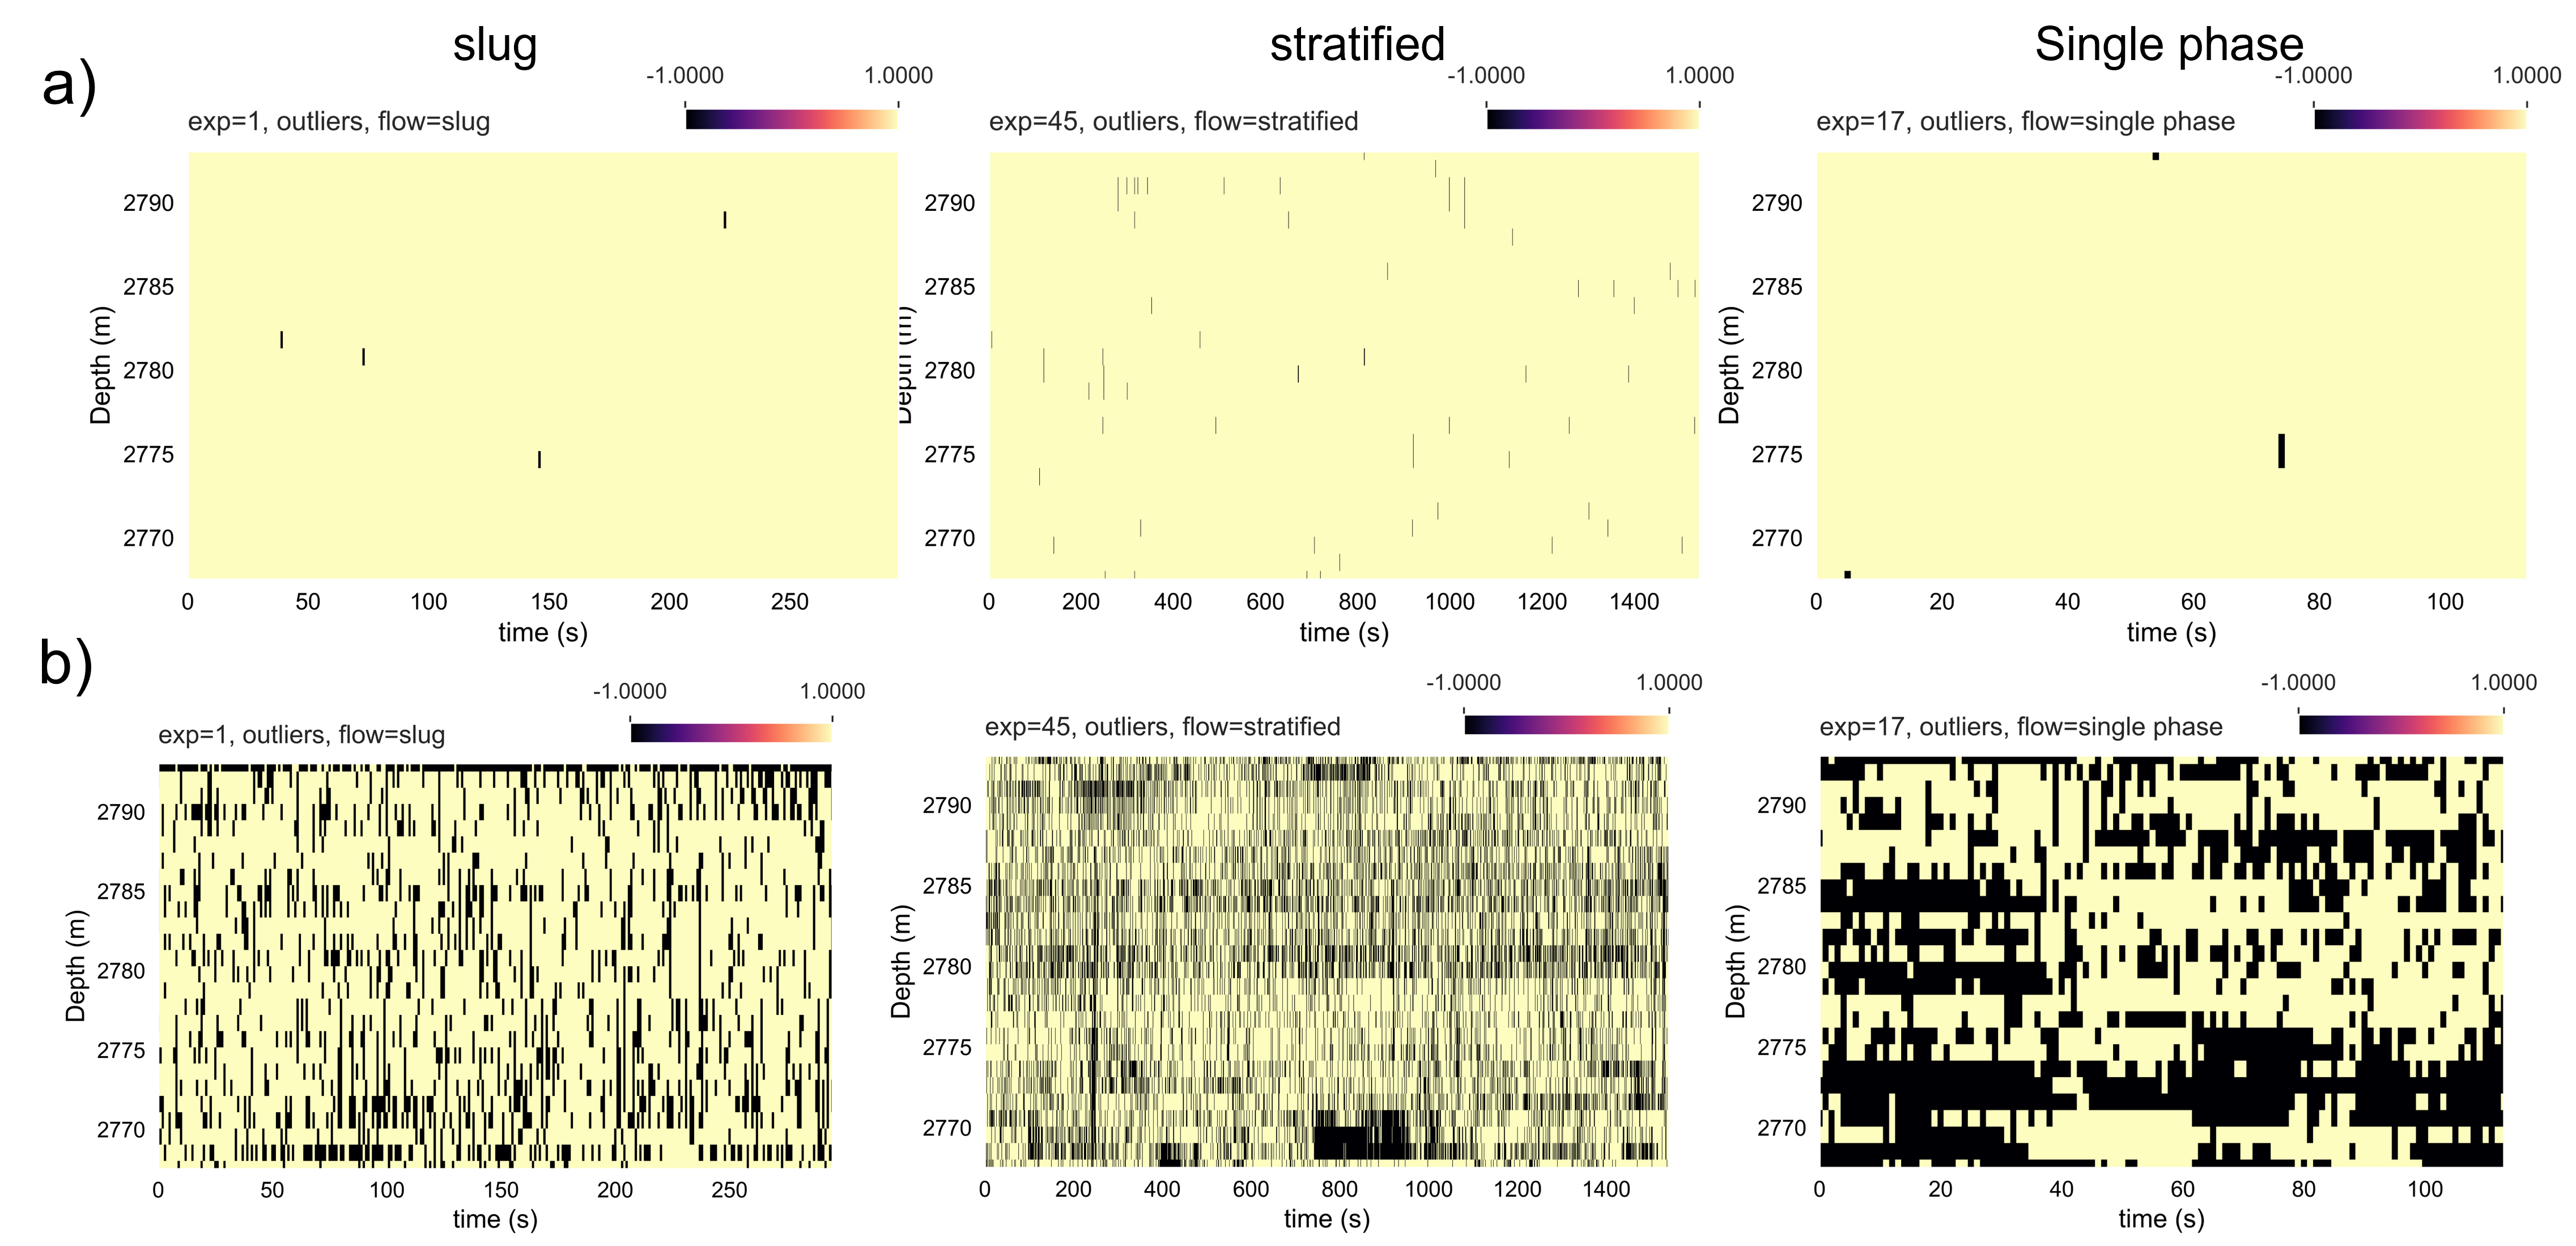
Fig1. Heatmaps of the LOF predictions (+1 and -1 predictions).} a). Heatmaps for the different flowtypes for the first LOF attempt with k-neighbours=20 and contamination=auto. +1 corresponds to inliers and -1 to outliers. b) Same for the second LOF attempt with k-neighbours=1000 and contamination=0.33.

## LOF first attempt
n_neighbour=20  and contamination="auto"

## opening data

In [ ]:
# adds log of feature1-4
# removes feature 1-4
# Includes depth as a feature
# separates into train and test set
# does StandardScaler() fit on train set and transform on all the data
train_set, test_set, train_labels, test_labels= data_cleaning.prepare_for_LOF("DS_test_DAS_seconds.csv")
x_train=pd.DataFrame.to_numpy(train_set)

In [ ]:
# fit the model for outlier detection (default)

clf = LocalOutlierFactor(n_neighbors=20,contamination='auto', novelty=False)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_train_pred = clf.fit_predict(x_train)
X_train_scores = clf.negative_outlier_factor_


In [ ]:
# include predictions as a new feature
data=pd.read_csv("DS_test_DAS_seconds.csv")
train_set["outliers"]=y_train_pred
train_set["flow"]=train_labels
train_set["exp_no"]=data["exp_no"]
train_set["outliers_score"]=X_train_scores
train_set["log_outliers_score"]=np.log(np.abs(X_train_scores+1))

print("Percentage of outliers:",np.count_nonzero(y_train_pred-1)/(len(y_train_pred)))

Percentage of outliers: 0.002476765870875268


In [ ]:
# plot in different color depending on flow
n_instances=1000
slug_score=train_set[train_set["flow"]=="slug"]["log_outliers_score"][0:n_instances]
strat_score=train_set[train_set["flow"]=="stratified"]["log_outliers_score"][0:n_instances]
single_score=train_set[train_set["flow"]=="single phase"]["log_outliers_score"][0:n_instances]
plt.scatter(range(n_instances), slug_score, s=3, label="slug")
plt.scatter(range(n_instances, 2*n_instances), strat_score, s=3, label="stratified")
plt.scatter(range(2*n_instances, 3*n_instances), single_score, s=3, label="single")
plt.legend(fontsize=16)
plt.xlabel("instance number", {'color': 'k', 'fontsize': 14})
plt.ylabel("log(|negative_outlier factor_-1|)", {'color': 'k', 'fontsize': 14})
plt.xticks( color='k', size=12)
plt.yticks( color='k', size=12)

filename="1_negative_outlier_factor_instances"
if not os.path.exists('figures'):
		os.mkdir('figures')
filename=os.path.join("figures",filename)
    
plt.savefig(filename+'.png',dpi=600, bbox_inches = "tight")  

plt.show()

### Heatmap 1 of LOF predictions

#### slug 1

Percentage of outliers 0.0005197505197505198


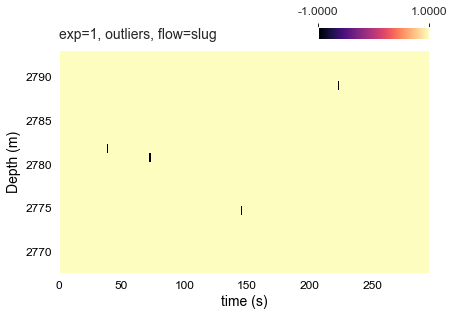

In [ ]:
# heatmap predictions slug

exp_no=1
feature="outliers"
flow_type=(train_set[train_set["exp_no"]==exp_no]["flow"]).unique()
title="exp="+str(exp_no)+ ", "+ feature+ ", flow="+flow_type[0]
filename="exp_"+str(exp_no)+ "_"+ feature+ "_flow_"+flow_type[0]


heatmap=train_set[train_set["exp_no"]==exp_no] # experiment 1
heatmap=heatmap.pivot(index='depth', columns='time', values=feature) # pivot so we can plot it

# function for pretty 2D map
x=heatmap.columns
y=heatmap.index
Z=heatmap.values
print("Percentage of outliers",np.count_nonzero(Z-1)/(len(Z)*len(Z[0])))

Plot_color_map.D2_map(x,y,Z,-1,1,"linear",title, "time (s)","Depth (m)",filename,dpi=900)

Percentage of outliers 1.0


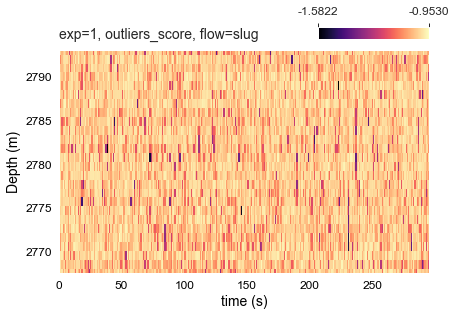

In [ ]:
# heatmap predictions slug

exp_no=1
feature="outliers_score"
flow_type=(train_set[train_set["exp_no"]==exp_no]["flow"]).unique()
title="exp="+str(exp_no)+ ", "+ feature+ ", flow="+flow_type[0]
filename="exp_"+str(exp_no)+ "_"+ feature+ "_flow_"+flow_type[0]


heatmap=train_set[train_set["exp_no"]==exp_no] # experiment 1
heatmap=heatmap.pivot(index='depth', columns='time', values=feature) # pivot so we can plot it

# function for pretty 2D map
x=heatmap.columns
y=heatmap.index
Z=heatmap.values
print("Percentage of outliers",np.count_nonzero(Z-1)/(len(Z)*len(Z[0])))

Plot_color_map.D2_map(x,y,Z,Z.min(),Z.max(),"loginear",title, "time (s)","Depth (m)",filename,dpi=900)

#### single phase 1

Percentage of outliers 0.001349527665317139


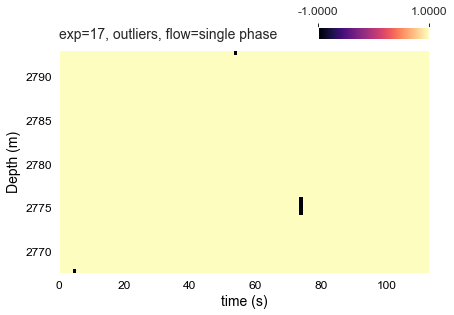

In [ ]:
# heatmap predictions slug

exp_no=17
feature="outliers"
flow_type=(train_set[train_set["exp_no"]==exp_no]["flow"]).unique()
title="exp="+str(exp_no)+ ", "+ feature+ ", flow="+flow_type[0]
filename="exp_"+str(exp_no)+ "_"+ feature+ "_flow_"+flow_type[0]


heatmap=train_set[train_set["exp_no"]==exp_no] # experiment 1
heatmap=heatmap.pivot(index='depth', columns='time', values=feature) # pivot so we can plot it

# function for pretty 2D map
x=heatmap.columns
y=heatmap.index
Z=heatmap.values
print("Percentage of outliers",np.count_nonzero(Z-1)/(len(Z)*len(Z[0])))

Plot_color_map.D2_map(x,y,Z,-1,1,"linear",title, "time (s)","Depth (m)",filename,dpi=900)

Percentage of outliers 1.0


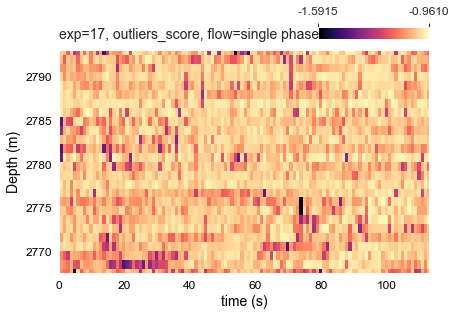

In [ ]:
# heatmap predictions single phase

exp_no=17
feature="outliers_score"
flow_type=(train_set[train_set["exp_no"]==exp_no]["flow"]).unique()
title="exp="+str(exp_no)+ ", "+ feature+ ", flow="+flow_type[0]
filename="exp_"+str(exp_no)+ "_"+ feature+ "_flow_"+flow_type[0]


heatmap=train_set[train_set["exp_no"]==exp_no] # experiment 1
heatmap=heatmap.pivot(index='depth', columns='time', values=feature) # pivot so we can plot it

# function for pretty 2D map
x=heatmap.columns
y=heatmap.index
Z=heatmap.values
print("Percentage of outliers",np.count_nonzero(Z-1)/(len(Z)*len(Z[0])))

Plot_color_map.D2_map(x,y,Z,Z.min(),Z.max(),"loginear",title, "time (s)","Depth (m)",filename,dpi=900)

#### stratified 1

Percentage of outliers 0.0015952938830450171


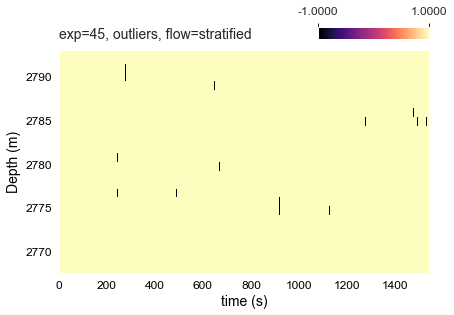

In [ ]:
# heatmap predictions stratified

exp_no=45
feature="outliers"
flow_type=(train_set[train_set["exp_no"]==exp_no]["flow"]).unique()
title="exp="+str(exp_no)+ ", "+ feature+ ", flow="+flow_type[0]
filename="exp_"+str(exp_no)+ "_"+ feature+ "_flow_"+flow_type[0]


heatmap=train_set[train_set["exp_no"]==exp_no] # experiment 1
heatmap=heatmap.pivot(index='depth', columns='time', values=feature) # pivot so we can plot it

# function for pretty 2D map
x=heatmap.columns
y=heatmap.index
Z=heatmap.values
print("Percentage of outliers",np.count_nonzero(Z-1)/(len(Z)*len(Z[0])))

Plot_color_map.D2_map(x,y,Z,-1,1,"linear",title, "time (s)","Depth (m)",filename,dpi=900)

Percentage of outliers 1.0


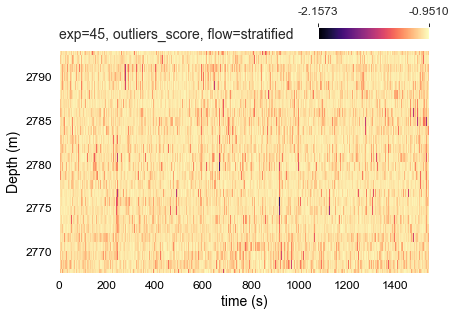

In [ ]:
# heatmap predictions slug

exp_no=45
feature="outliers_score"
flow_type=(train_set[train_set["exp_no"]==exp_no]["flow"]).unique()
title="exp="+str(exp_no)+ ", "+ feature+ ", flow="+flow_type[0]
filename="exp_"+str(exp_no)+ "_"+ feature+ "_flow_"+flow_type[0]


heatmap=train_set[train_set["exp_no"]==exp_no] # experiment 1
heatmap=heatmap.pivot(index='depth', columns='time', values=feature) # pivot so we can plot it

# function for pretty 2D map
x=heatmap.columns
y=heatmap.index
Z=heatmap.values
print("Percentage of outliers",np.count_nonzero(Z-1)/(len(Z)*len(Z[0])))

Plot_color_map.D2_map(x,y,Z,Z.min(),Z.max(),"loginear",title, "time (s)","Depth (m)",filename,dpi=900)

### Visualize distribution 1

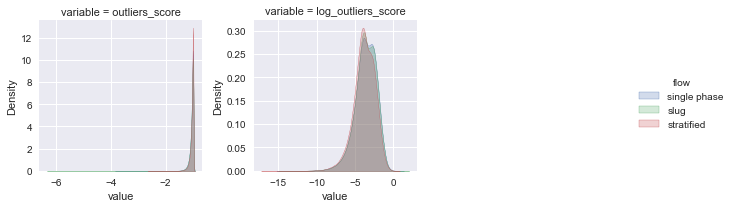

In [ ]:
plt.style.use('seaborn')
column=["outliers_score", "log_outliers_score"]
df2 = pd.melt(train_set, id_vars='flow', value_vars=column, value_name='value')
g = sns.FacetGrid(df2, col="variable", hue="flow", sharex=False, sharey=False, col_wrap=3, legend_out=True)
#g.set(xlim=(-6, -0.9))
g.map(sns.kdeplot, "value", fill=True)
g.add_legend()

filename="data_distribution"
if not os.path.exists('figures'):
		os.mkdir('figures')
filename=os.path.join("figures",filename)
    
plt.savefig(filename+'.png',dpi=600, bbox_inches = "tight")  

plt.show()

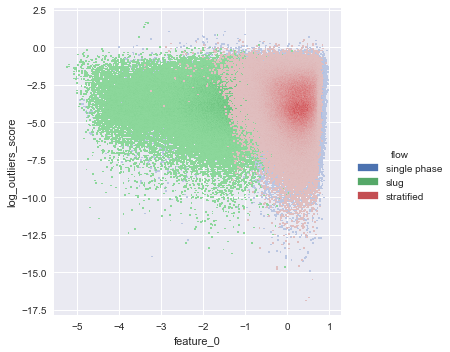

In [ ]:
sns.displot(data=train_set, x="feature_0", y="log_outliers_score"  , hue="flow")

## LOF second attempt
n_neighbour=20  and contamination=0.33

30% of the points will be seen as outliers. Hopefully this corresponds to a whole class

In [ ]:
# fit the model for outlier detection (default)

clf = LocalOutlierFactor(n_neighbors=1000,contamination=0.33, novelty=False)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_train_pred = clf.fit_predict(x_train)
X_train_scores = clf.negative_outlier_factor_


In [ ]:
# include predictions as a new feature

train_set["outliers"]=y_train_pred
train_set["flow"]=train_labels
train_set["exp_no"]=train_set["exp_no"]
train_set["outliers_score"]=X_train_scores
train_set["log_outliers_score"]=np.log(np.abs(X_train_scores+1))

print("Percentage of outliers:",np.count_nonzero(y_train_pred-1)/(len(y_train_pred)))

Percentage of outliers: 0.3300001541235763


### Figure 2

Negative outlier factor for different instances. There is not any evident pattern in these data. 

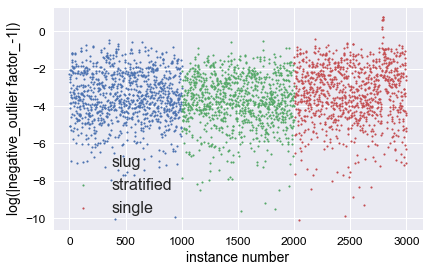

In [ ]:
# plot in different color depending on flow
n_instances=1000
slug_score=train_set[train_set["flow"]=="slug"]["log_outliers_score"][0:n_instances]
strat_score=train_set[train_set["flow"]=="stratified"]["log_outliers_score"][0:n_instances]
single_score=train_set[train_set["flow"]=="single phase"]["log_outliers_score"][0:n_instances]
plt.scatter(range(n_instances), slug_score, s=3, label="slug")
plt.scatter(range(n_instances, 2*n_instances), strat_score, s=3, label="stratified")
plt.scatter(range(2*n_instances, 3*n_instances), single_score, s=3, label="single")
plt.legend(fontsize=16)
plt.xlabel("instance number", {'color': 'k', 'fontsize': 14})
plt.ylabel("log(|negative_outlier factor_-1|)", {'color': 'k', 'fontsize': 14})
plt.xticks( color='k', size=12)
plt.yticks( color='k', size=12)

filename="2_negative_outlier_factor_instances"
if not os.path.exists('figures'):
		os.mkdir('figures')
filename=os.path.join("figures",filename)
    
plt.savefig(filename+'.png',dpi=600, bbox_inches = "tight")  

plt.show()

### Heatmap 2 of LOF predictions

#### slug 2

Percentage of outliers 0.2171257796257796


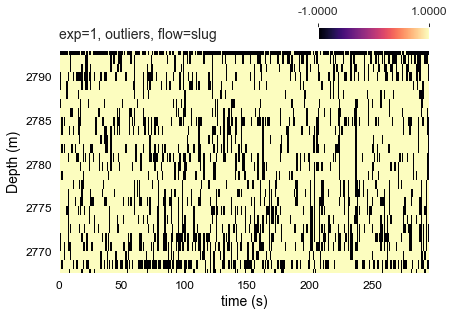

In [ ]:
# heatmap predictions slug

exp_no=1
feature="outliers"
flow_type=(train_set[train_set["exp_no"]==exp_no]["flow"]).unique()
title="exp="+str(exp_no)+ ", "+ feature+ ", flow="+flow_type[0]
filename="2_exp_"+str(exp_no)+ "_"+ feature+ "_flow_"+flow_type[0]


heatmap=train_set[train_set["exp_no"]==exp_no] # experiment 1
heatmap=heatmap.pivot(index='depth', columns='time', values=feature) # pivot so we can plot it

# function for pretty 2D map
x=heatmap.columns
y=heatmap.index
Z=heatmap.values
print("Percentage of outliers",np.count_nonzero(Z-1)/(len(Z)*len(Z[0])))

Plot_color_map.D2_map(x,y,Z,-1,1,"linear",title, "time (s)","Depth (m)",filename,dpi=900)

Percentage of outliers 1.0


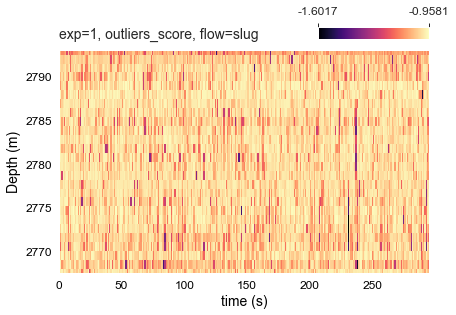

In [ ]:
# heatmap predictions slug

exp_no=1
feature="outliers_score"
flow_type=(train_set[train_set["exp_no"]==exp_no]["flow"]).unique()
title="exp="+str(exp_no)+ ", "+ feature+ ", flow="+flow_type[0]
filename="2_exp_"+str(exp_no)+ "_"+ feature+ "_flow_"+flow_type[0]


heatmap=train_set[train_set["exp_no"]==exp_no] # experiment 1
heatmap=heatmap.pivot(index='depth', columns='time', values=feature) # pivot so we can plot it

# function for pretty 2D map
x=heatmap.columns
y=heatmap.index
Z=heatmap.values
print("Percentage of outliers",np.count_nonzero(Z-1)/(len(Z)*len(Z[0])))

Plot_color_map.D2_map(x,y,Z,Z.min(),Z.max(),"loginear",title, "time (s)","Depth (m)",filename,dpi=900)

#### single phase 2

Percentage of outliers 0.46794871794871795


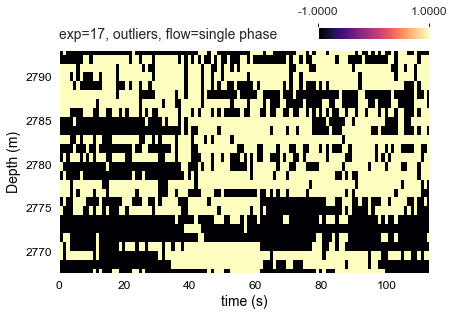

In [ ]:
# heatmap predictions slug

exp_no=17
feature="outliers"
flow_type=(train_set[train_set["exp_no"]==exp_no]["flow"]).unique()
title="exp="+str(exp_no)+ ", "+ feature+ ", flow="+flow_type[0]
filename="2_exp_"+str(exp_no)+ "_"+ feature+ "_flow_"+flow_type[0]


heatmap=train_set[train_set["exp_no"]==exp_no] # experiment 1
heatmap=heatmap.pivot(index='depth', columns='time', values=feature) # pivot so we can plot it

# function for pretty 2D map
x=heatmap.columns
y=heatmap.index
Z=heatmap.values
print("Percentage of outliers",np.count_nonzero(Z-1)/(len(Z)*len(Z[0])))

Plot_color_map.D2_map(x,y,Z,-1,1,"linear",title, "time (s)","Depth (m)",filename,dpi=900)

Percentage of outliers 1.0


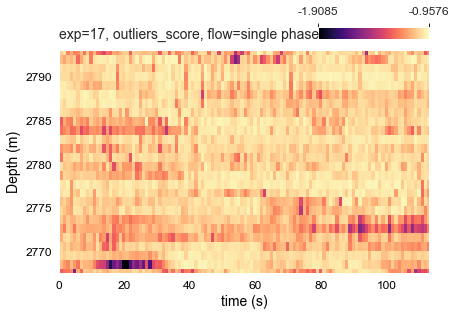

In [ ]:
# heatmap predictions single phase

exp_no=17
feature="outliers_score"
flow_type=(train_set[train_set["exp_no"]==exp_no]["flow"]).unique()
title="exp="+str(exp_no)+ ", "+ feature+ ", flow="+flow_type[0]
filename="2_exp_"+str(exp_no)+ "_"+ feature+ "_flow_"+flow_type[0]


heatmap=train_set[train_set["exp_no"]==exp_no] # experiment 1
heatmap=heatmap.pivot(index='depth', columns='time', values=feature) # pivot so we can plot it

# function for pretty 2D map
x=heatmap.columns
y=heatmap.index
Z=heatmap.values
print("Percentage of outliers",np.count_nonzero(Z-1)/(len(Z)*len(Z[0])))

Plot_color_map.D2_map(x,y,Z,Z.min(),Z.max(),"loginear",title, "time (s)","Depth (m)",filename,dpi=900)

#### stratified 2

Percentage of outliers 0.2636970935739568


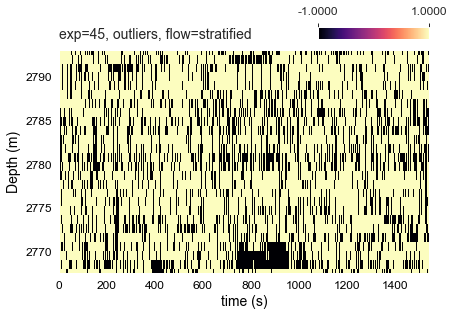

In [ ]:
# heatmap predictions stratified

exp_no=45
feature="outliers"
flow_type=(train_set[train_set["exp_no"]==exp_no]["flow"]).unique()
title="exp="+str(exp_no)+ ", "+ feature+ ", flow="+flow_type[0]
filename="2_exp_"+str(exp_no)+ "_"+ feature+ "_flow_"+flow_type[0]


heatmap=train_set[train_set["exp_no"]==exp_no] # experiment 1
heatmap=heatmap.pivot(index='depth', columns='time', values=feature) # pivot so we can plot it

# function for pretty 2D map
x=heatmap.columns
y=heatmap.index
Z=heatmap.values
print("Percentage of outliers",np.count_nonzero(Z-1)/(len(Z)*len(Z[0])))

Plot_color_map.D2_map(x,y,Z,-1,1,"linear",title, "time (s)","Depth (m)",filename,dpi=900)

Percentage of outliers 1.0


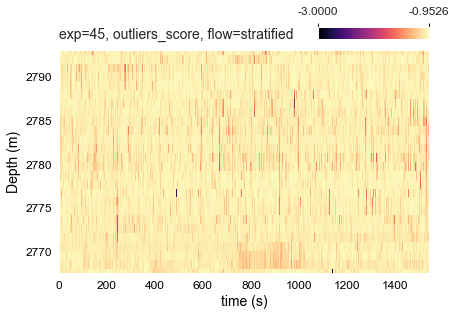

In [ ]:
# heatmap predictions stratified

exp_no=45
feature="outliers_score"
flow_type=(train_set[train_set["exp_no"]==exp_no]["flow"]).unique()
title="exp="+str(exp_no)+ ", "+ feature+ ", flow="+flow_type[0]
filename="2_exp_"+str(exp_no)+ "_"+ feature+ "_flow_"+flow_type[0]


heatmap=train_set[train_set["exp_no"]==exp_no] # experiment 1
heatmap=heatmap.pivot(index='depth', columns='time', values=feature) # pivot so we can plot it

# function for pretty 2D map
x=heatmap.columns
y=heatmap.index
Z=heatmap.values
print("Percentage of outliers",np.count_nonzero(Z-1)/(len(Z)*len(Z[0])))

Plot_color_map.D2_map(x,y,Z,-3,Z.max(),"loginear",title, "time (s)","Depth (m)",filename,dpi=900)

### Visualize distribution 2

### Figure 3
Distribution of negative outlier factor for the different flow types. a) Distribution of the negative outlier factor. b) Distribution of the logarithm of the negative outlier factor. The algorithm settings are k-neighbours=1000 and contamination=0.33.

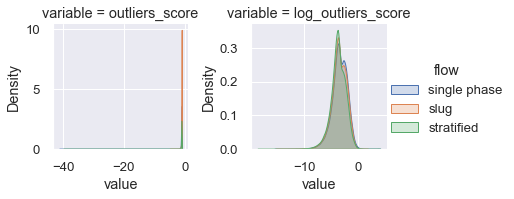

In [ ]:
plt.style.use('seaborn')
sns.set(font_scale=1.2)
column=["outliers_score", "log_outliers_score"]
df2 = pd.melt(train_set, id_vars='flow', value_vars=column, value_name='value')
g = sns.FacetGrid(df2, col="variable", hue="flow", sharex=False, sharey=False, col_wrap=2, legend_out=True)
#g.set(xlim=(-6, -0.9))
g.map(sns.kdeplot, "value", fill=True)
g.add_legend()

filename="2_data_distribution"
if not os.path.exists('figures'):
		os.mkdir('figures')
filename=os.path.join("figures",filename)
    
plt.savefig(filename+'.png',dpi=600, bbox_inches = "tight")  

plt.show()

### Figure 4
Joint distribution between feature0 and the logarithm of the negative outlier factor.

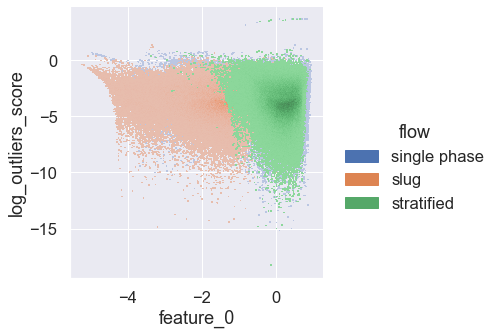

In [ ]:
sns.set(font_scale=1.5)
sns.displot(data=train_set, x="feature_0", y="log_outliers_score"  , hue="flow")

filename="2_joint_distribution"
if not os.path.exists('figures'):
		os.mkdir('figures')
filename=os.path.join("figures",filename)
    
plt.savefig(filename+'.png',dpi=600, bbox_inches = "tight")  

plt.show()

## Conclussions about using LOF

**Can you draw any conclusions about how useful negative outlier factor would be as a feature?**


The negative outlier factor is the ratio between the density of each instance and the density of its k-neighbours. In Scikitlearn, the most normal instances have a negative outlier factor close to -1, while the outliers have more negative factors. Fig.2 shows the outlier factor calculated as $log(abs(negative\_outlier\_ factor\_ -1))$ for 3000 thousand instances. To the naked eye, there is not any difference between the outlier factor of different flows.



Fig.3 shows the the distribution of $\mathrm{negative\_outlier\_ factor\_}$ for the different flow type classes. For both methods, the distributions are supperposed and seem quite similar. Lastly, Fig.4 shows the joint distribution of feature0 and the negative outlier factor. This further emphasises the fact that the negative outlier facor will not be useful as a new feature.


# Autoencoder

**Using PyTorch, implement an auto encoder with a two-dimensional hidden layer for the flow classification data** 

The implementation of the Autoencoder can be found in the Folder Autoencoder/Autoencoder.py It has two different architectures

Autoencoder_1layer has an encoder with a fully connected layer of n_hidden_1 units, followed by a 2-unit layer. The decoder is symmetrical to the autoencoder an has another layer with n_hidden units

Autoencoder_2layers has an encoder with two fully connected layer with units n_hidden_1 and n_hidden_2, respectively. The decoder is symmetrical.

The unit activation is done with the function relu.

**One layer Autoencoder architecture**
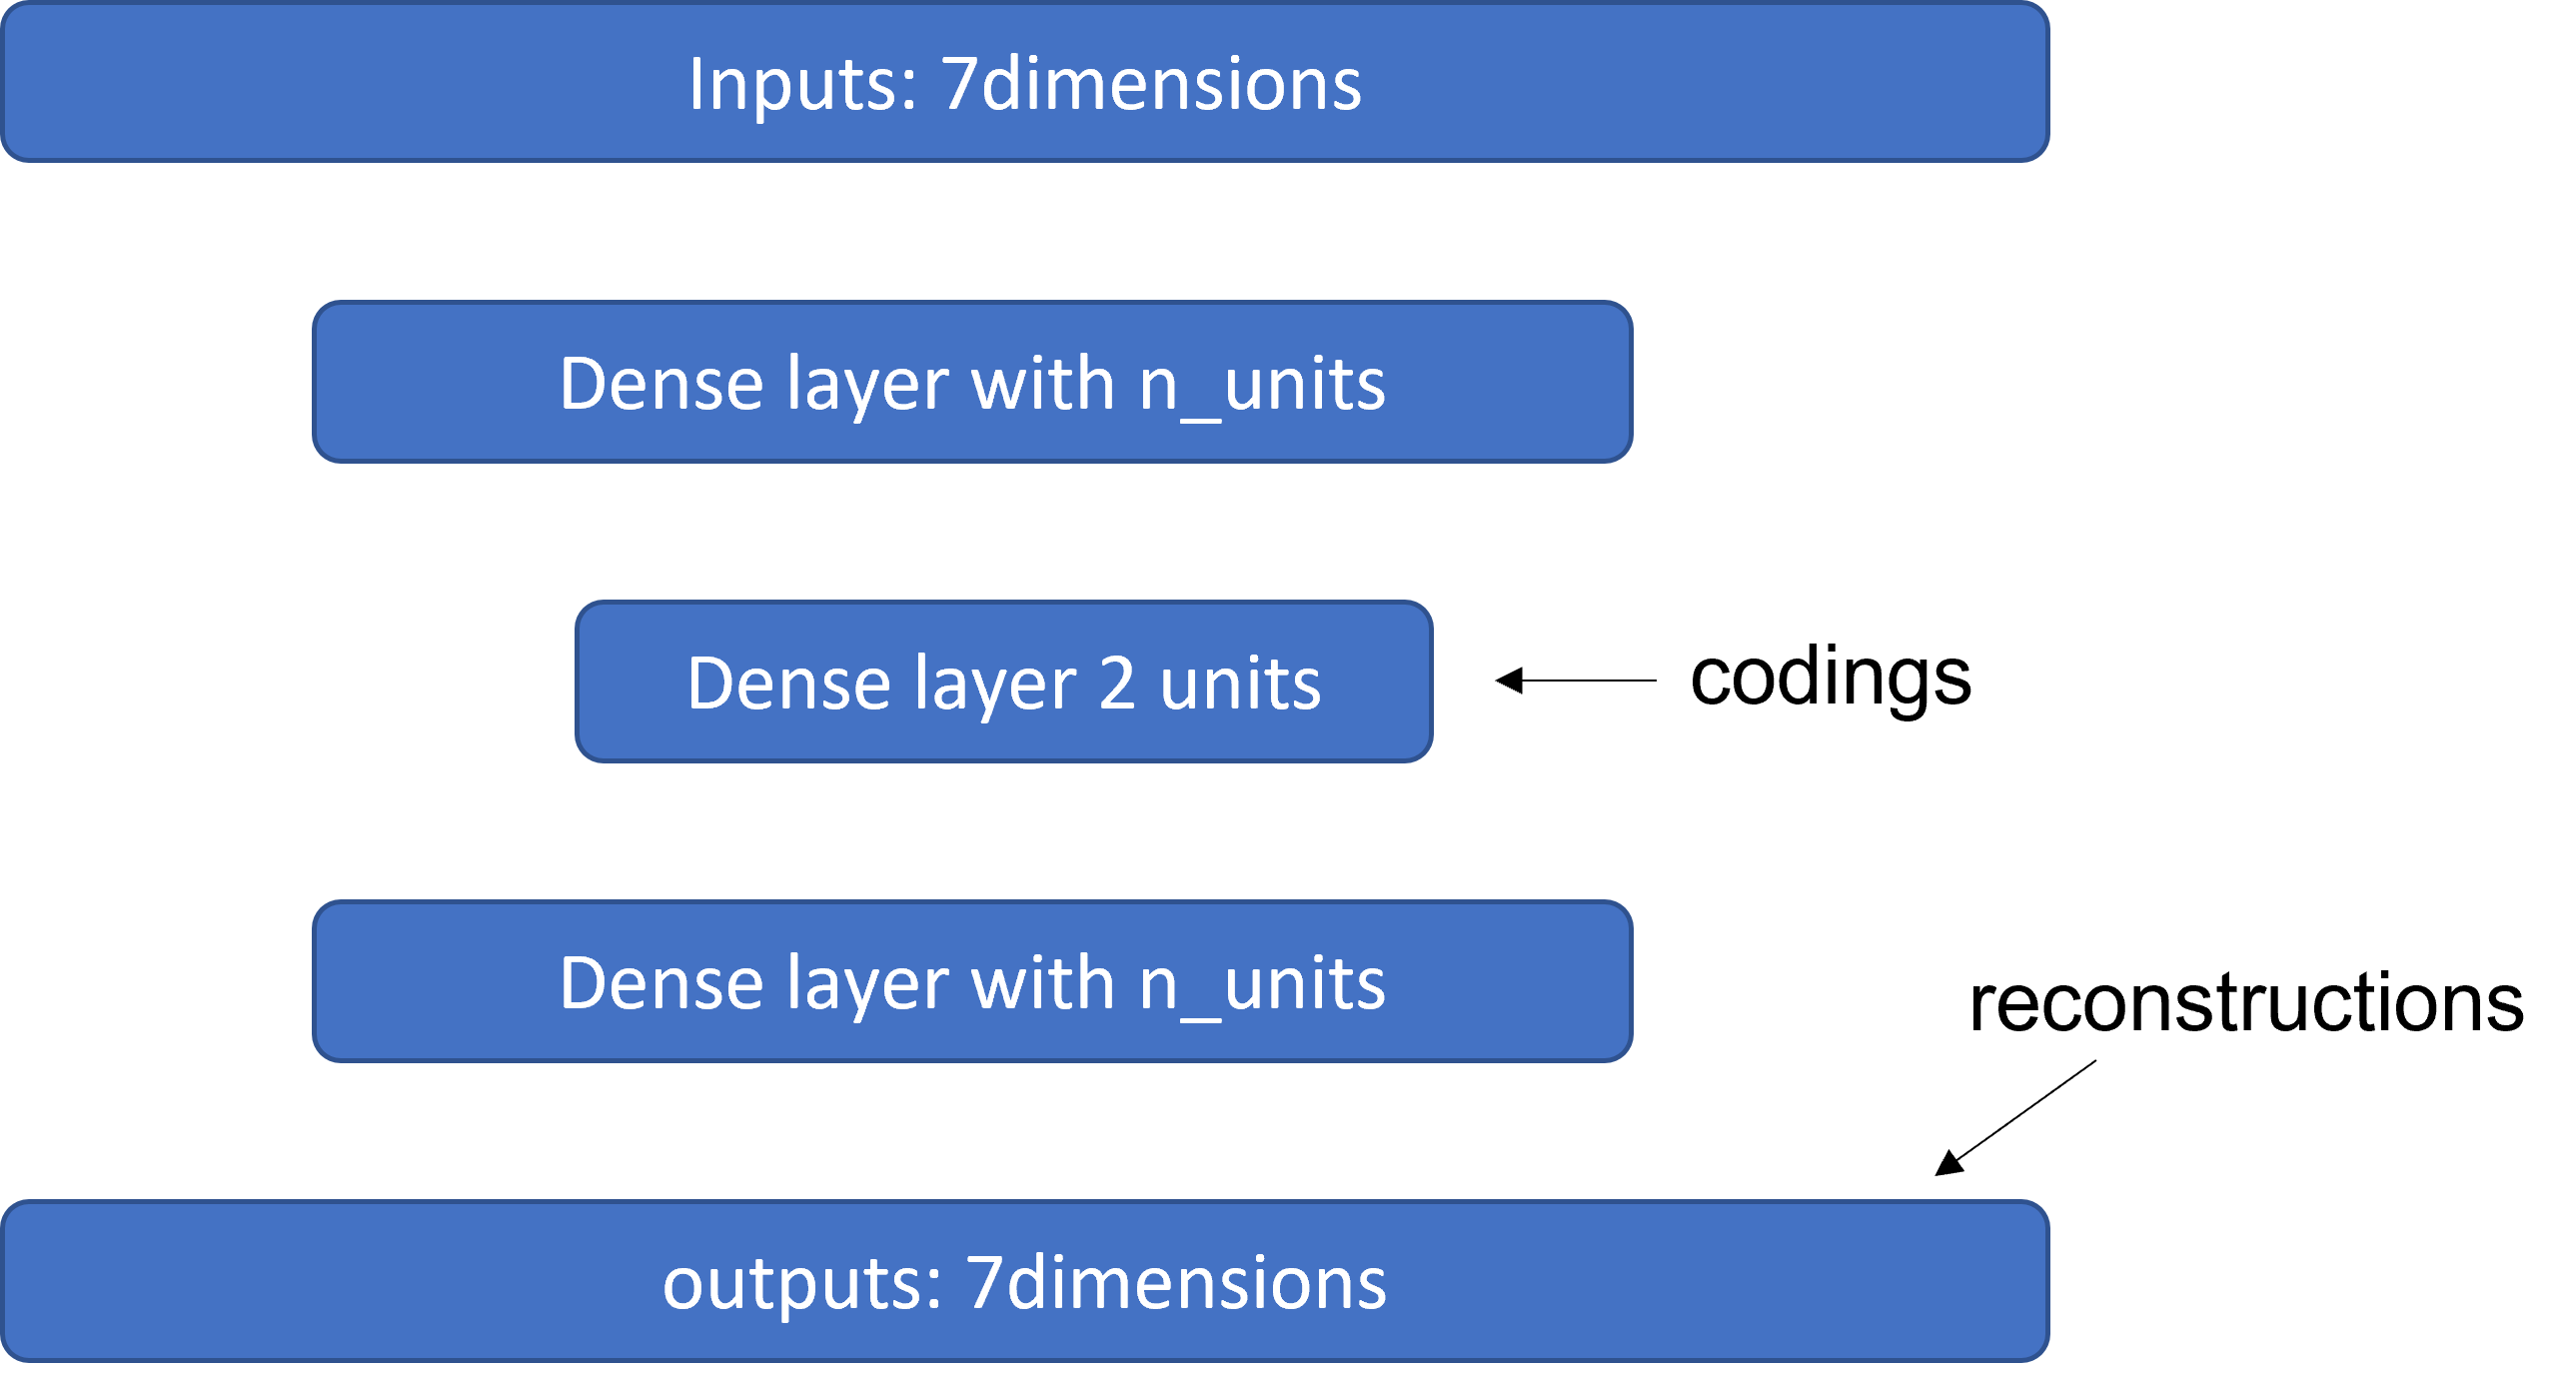

## Import data

In [4]:
train_set, test_set, train_labels, test_labels= data_cleaning.prepare_for_LOF("DS_test_DAS_seconds.csv")

# Shuffle
shuffle_index = np.random.permutation(train_set.shape[0])
train_set, train_labels = train_set.iloc[shuffle_index], train_labels.iloc[shuffle_index]
train_labels=pd.Series.to_frame(train_labels)

# convert into tensor
myDs_train=Autoencoder.MyDataset(set_values=train_set, labels=train_labels)
myDs_test=Autoencoder.MyDataset(set_values=test_set, labels=test_labels)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
# in case we want to inverse the label transformation
targets = myDs_test.le.inverse_transform([2])
targets

array(['stratified'], dtype=object)

## Define autoencoder

## K-fold validation and training

I used as a loss function for the autoencoder the mean square error between the inputs and the outputs of the autoencoder.

The loss of the train and validation set is saved after each epoch.

In [16]:
# Define parameters
n_hidden_1=10
n_hidden_2=5
n_layers=1

num_epochs=5
batch_size=128
k=4
splits = StratifiedKFold(n_splits=k,  shuffle=True) # make stratified k-fold
foldperf={}


#  use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# mean-squared error loss
criterion = nn.MSELoss()


#K-FOLD VALIDATION
batch_loss=[]

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(myDs_train)),train_labels )):
  print('Fold {}'.format(fold + 1))

  #Separates data into train and validation
  train_sampler = SubsetRandomSampler(train_idx)

  ## Colab can work with a higher num of owrkers, speeding up computation time
  train_loader = DataLoader(myDs_train, batch_size=batch_size, sampler=train_sampler,  num_workers=2, pin_memory=True)
  val_set = myDs_train[val_idx][0]

  if n_layers==1:
    # create a model from `AE` autoencoder class
    # load it to the specified device, either gpu or cpu
    model = Autoencoder.AE_1layer(n_hidden=n_hidden_1,input_shape=7).to(device)

    # create an optimizer object
    # Adam optimizer with learning rate 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  
  if n_layers==2:
    model = Autoencoder.AE_2layer(n_hidden_1=n_hidden_1, n_hidden_2=n_hidden_2, input_shape=7).to(device)

    # create an optimizer object
    # Adam optimizer with learning rate 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  

  # Create a lambda learning schedule
  # For some reason the schedule was making the loss much higher, even in the first batch
  #lambda1 = lambda epoch: 0.67 ** epoch
  #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

  history = {'train_loss': [], 'val_loss': []}

  epochs=5
  epoch_loss=[]
  for epoch in range(epochs):
      # TRAINING
      loss = 0
      for batch_features, _ in train_loader:
          # reshape mini-batch data to [N, 7] matrix
          # load it to the active device
          batch_features = batch_features.view(-1, 7).to(device)
          
          # reset the gradients back to zero
          # PyTorch accumulates gradients on subsequent backward passes
          optimizer.zero_grad()
          
          # compute reconstructions
          outputs = model(batch_features)
          
          # compute training reconstruction loss
          train_loss = criterion(outputs, batch_features)
          
          # compute accumulated gradients
          train_loss.backward()
          
          # perform parameter update based on current gradients
          optimizer.step()
          
          # add the mini-batch training loss to epoch loss
          loss += train_loss.item()
          if fold==0 and epoch==0:
            batch_loss=np.append(batch_loss, train_loss.item())
      #scheduler.step()
      
      # VALIDATION
      with torch.no_grad():
          val_output = model.forward(val_set)

      # compute the epoch loss
      training_loss = loss / len(train_loader)
      val_loss = criterion(val_output, val_set)

      print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Val Loss:{:.3f} ".format(epoch + 1, num_epochs, training_loss, val_loss))
      history['train_loss'].append(training_loss)
      history['val_loss'].append(val_loss.item())


  foldperf['fold{}'.format(fold+1)] = history  

Fold 1
Epoch:1/5 AVG Training Loss:0.123 AVG Val Loss:0.065 
Epoch:2/5 AVG Training Loss:0.061 AVG Val Loss:0.058 
Epoch:3/5 AVG Training Loss:0.056 AVG Val Loss:0.054 
Epoch:4/5 AVG Training Loss:0.053 AVG Val Loss:0.052 
Epoch:5/5 AVG Training Loss:0.052 AVG Val Loss:0.052 
Fold 2
Epoch:1/5 AVG Training Loss:0.322 AVG Val Loss:0.270 
Epoch:2/5 AVG Training Loss:0.225 AVG Val Loss:0.195 
Epoch:3/5 AVG Training Loss:0.184 AVG Val Loss:0.176 
Epoch:4/5 AVG Training Loss:0.170 AVG Val Loss:0.167 
Epoch:5/5 AVG Training Loss:0.162 AVG Val Loss:0.161 
Fold 3
Epoch:1/5 AVG Training Loss:0.123 AVG Val Loss:0.078 
Epoch:2/5 AVG Training Loss:0.073 AVG Val Loss:0.068 
Epoch:3/5 AVG Training Loss:0.069 AVG Val Loss:0.068 
Epoch:4/5 AVG Training Loss:0.068 AVG Val Loss:0.068 
Epoch:5/5 AVG Training Loss:0.068 AVG Val Loss:0.067 
Fold 4
Epoch:1/5 AVG Training Loss:0.142 AVG Val Loss:0.067 
Epoch:2/5 AVG Training Loss:0.064 AVG Val Loss:0.063 
Epoch:3/5 AVG Training Loss:0.061 AVG Val Loss:0.061 


## Save data and model

Each architecture is stored in its own folder inside the folder "Models".

I have saved three files corresponding to the model training weights ("model.pth"), the losses of the traning and validation set at each epoch and flod ("information.json") and the batch loss for the first fold ("batch_loss.npz")

In [ ]:
if n_layers==1:
  pathname=str(n_layers)+"Layer_"+"nunits1_"+str(n_hidden_1)
  pathname=os.path.join("models",pathname)
  if not os.path.exists(pathname):
      os.mkdir(pathname)

if n_layers==2:
  pathname=str(n_layers)+"Layer_"+"nunits1_"+str(n_hidden_1)+"_"+"nunits2_"+str(n_hidden_2)
  pathname=os.path.join("models",pathname)
  if not os.path.exists(pathname):
      os.mkdir(pathname)

## Save model
filename="model.pth"
filename=os.path.join(pathname,filename)
torch.save(model.state_dict(), filename)

## Save foldperf
filename="information.json"
filename=os.path.join(pathname,filename)
with open(filename, 'w') as file:
    json.dump(foldperf, file)


## Save batch_loss
filename="batch_loss.npz"
filename=os.path.join(pathname,filename)
np.savez(filename,batch_loss=batch_loss)


## Load data and model

Loads a given model and creates a specific folder with the format "n_layer_nunits1_n_units2" inside the folder figures to store the plots of that model

In [8]:
# Define parameters
n_hidden_1=5
n_hidden_2=10
n_layers=2

train_set, test_set, train_labels, test_labels= data_cleaning.prepare_for_LOF("DS_test_DAS_seconds.csv")
batch_loss, foldperf, model=Autoencoder.load_model(n_layers,n_hidden_1, n_hidden_2=n_hidden_2)
criterion = nn.MSELoss()

In [9]:
X_test=pd.DataFrame.to_numpy(test_set)
X_test=torch.FloatTensor(X_test)
with torch.no_grad():
        X_output = model.forward(X_test)
train_loss=criterion(X_test,X_output)
train_loss

tensor(0.0549)

In [10]:
X_train=pd.DataFrame.to_numpy(train_set)
X_train=torch.FloatTensor(X_train)
with torch.no_grad():
        X_output = model.forward(X_train)
train_loss=criterion(X_train,X_output)
train_loss

tensor(0.0678)

In [11]:
if n_layers==1:
  pathname=str(n_layers)+"Layer_"+"nunits1_"+str(n_hidden_1)
  pathname=os.path.join("figures",pathname)
  if not os.path.exists(pathname):
      os.mkdir(pathname)

if n_layers==2:
  pathname=str(n_layers)+"Layer_"+"nunits1_"+str(n_hidden_1)+"_"+"nunits2_"+str(n_hidden_2)
  pathname=os.path.join("figures",pathname)
  if not os.path.exists(pathname):
      os.mkdir(pathname)

## Figure 5
Loss per batch during the first fold. We can see how the loss drops almost exponentially.

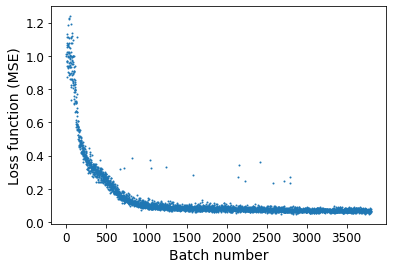

In [12]:
# Figure for looking the loss per batch
filename="loss_at_each_batch"
filename=os.path.join(pathname,filename)
plt.scatter(range(len(batch_loss)), batch_loss,s=1)
plt.xlabel("Batch number", {'color': 'k', 'fontsize': 14})
plt.ylabel("Loss function (MSE)", {'color': 'k', 'fontsize': 14})
plt.xticks( color='k', size=12)
plt.yticks( color='k', size=12)
plt.savefig(filename+'.png',dpi=600, bbox_inches = "tight")  

plt.show()


## Figure 6
Comparison between the validation and training loss for one of the folds during 5 epochs. After the first two epochs the loss function is already converging. There is not overfitting because there is not a gap between the loss in the validation and the training set.

The black dot respresents the loss in the test set.

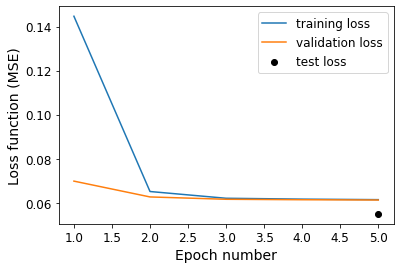

In [13]:
# Figure for comparing validation with test and training
filename="loss_per_epoch_train_val"
filename=os.path.join(pathname,filename)

X_test=pd.DataFrame.to_numpy(test_set)
X_test=torch.FloatTensor(X_test)

with torch.no_grad():
        X_output = model.forward(X_test)
test_loss=criterion(X_test,X_output)

f=1
plt.plot(range(1,1+len(foldperf['fold{}'.format(f)]["train_loss"])), foldperf['fold{}'.format(f)]["train_loss"], label="training loss")
plt.plot(range(1,1+len(foldperf['fold{}'.format(f)]["val_loss"])), foldperf['fold{}'.format(f)]["val_loss"], label="validation loss")
plt.scatter(len(foldperf['fold{}'.format(f)]["train_loss"]), test_loss, color="k", label="test loss")
plt.xlabel("Epoch number", {'color': 'k', 'fontsize': 14})
plt.ylabel("Loss function (MSE)", {'color': 'k', 'fontsize': 14})
plt.xticks( color='k', size=12)
plt.yticks( color='k', size=12)
plt.legend(fontsize=12)
plt.savefig(filename+'.png',dpi=600, bbox_inches = "tight")  

plt.show()


## Figure 7

Comaprison between the fuatures of a random input (blue), its reconstruction (orange) and the difference between the input and the reconstruction (green).

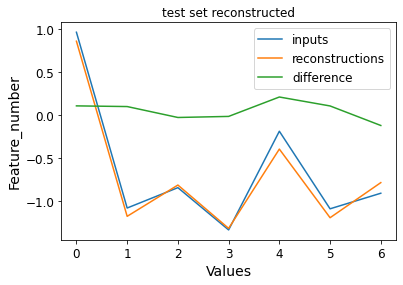

In [14]:
# Figure compares features of input and reconstructure
filename="input_vs_reconstruction"
filename=os.path.join(pathname,filename)

n=1000
plt.plot(X_test[n], label="inputs")
plt.plot(X_output[n], label="reconstructions")
plt.plot(X_test[n]-X_output[n], label="difference")

plt.title("test set reconstructed")
plt.xlabel("Values", {'color': 'k', 'fontsize': 14})
plt.ylabel("Feature_number", {'color': 'k', 'fontsize': 14})
plt.xticks( color='k', size=12)
plt.yticks( color='k', size=12)
plt.legend(fontsize=12)
plt.savefig(filename+'.png',dpi=600, bbox_inches = "tight")  

plt.show()


## Autoencoder comparison

## Figure 8

Comparison between the different architectures. In blue is the loss average calculated with k-fold validation. The error bars corresponds to their standard deviation. The red points are the loss in the test set.

In the one layer architecture, a small number of units is preferable to prevent models with high variance. The variance could be further reduced with Dropout layers, denoiser autoencoders and l2 parameters. See the next steps section for more information.

The two layer architecture is more complex and has a lot of variation. The more layers we have, the more regulation we should add to avoid overfitting





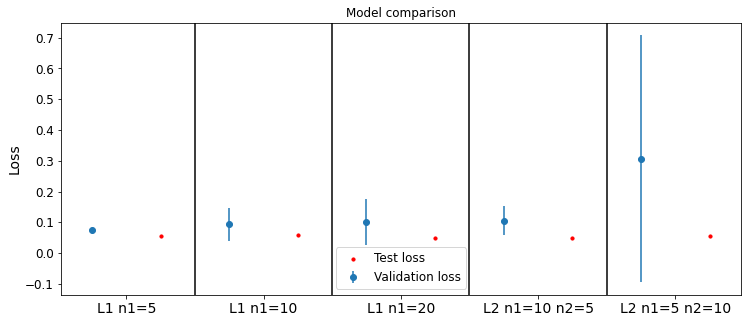

In [15]:
from flow_class_vir.Autoencoder import load_model, Cross_val_loss, test_loss
import math
# loads the model
x, l1_h1_10_foldperf, l1_h1_10_model=load_model(n_layers=1,n_hidden_1=10, n_hidden_2=0)
# average of the validation loss for each fold
l1_h1_10_val=Cross_val_loss(l1_h1_10_foldperf)
# test loss
l1_h1_10_test=test_loss(l1_h1_10_model, X_test)


x, l1_h1_5_foldperf, l1_h1_5_model=load_model(n_layers=1,n_hidden_1=5, n_hidden_2=0)
l1_h1_5_val=Cross_val_loss(l1_h1_5_foldperf)
l1_h1_5_test=test_loss(l1_h1_5_model, X_test)


x, l1_h1_20_foldperf, l1_h1_20_model=load_model(n_layers=1,n_hidden_1=20, n_hidden_2=0)
l1_h1_20_val=Cross_val_loss(l1_h1_20_foldperf)
l1_h1_20_test=test_loss(l1_h1_20_model, X_test)

x, l2_h1_10_h2_5_foldperf, l2_h1_10_h2_5_model=load_model(n_layers=2,n_hidden_1=10, n_hidden_2=5)
l2_h1_10_h2_5_val=Cross_val_loss(l2_h1_10_h2_5_foldperf)
l2_h1_10_h2_5_test=test_loss(l2_h1_10_h2_5_model, X_test)

x, l2_h1_5_h2_10_foldperf, l2_h1_5_h2_10_model=load_model(n_layers=2,n_hidden_1=5, n_hidden_2=10)
l2_h1_5_h2_10_val=Cross_val_loss(l2_h1_5_h2_10_foldperf)
l2_h1_5_h2_10_test=test_loss(l2_h1_5_h2_10_model, X_test)



fig_width_pt = 880.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27				# Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0		 # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt	# width in inches
fig_height = 5	# height in inches
fig_size =	[fig_width,fig_height]
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['figure.figsize'] = fig_size
#figure_style()


fig, ax = plt.subplots()

val_mean=[np.mean(l1_h1_5_val), np.mean(l1_h1_10_val), np.mean(l1_h1_20_val), np.mean(l2_h1_10_h2_5_val),  np.mean(l2_h1_5_h2_10_val)]
val_std=[np.std(l1_h1_5_val), np.std(l1_h1_10_val), np.std(l1_h1_20_val), np.std(l2_h1_10_h2_5_val), np.std(l2_h1_5_h2_10_val)]
test_total=[l1_h1_5_test, l1_h1_10_test, l1_h1_20_test, l2_h1_10_h2_5_test, l2_h1_5_h2_10_test]
plt.errorbar([0,2,4, 6,8], val_mean, yerr=val_std, fmt="o", label="Validation loss")
plt.xticks([0.5,2.5,4.5, 6.5,8.5], ["L1 n1=5","L1 n1=10", "L1 n1=20" , "L2 n1=10 n2=5",  "L2 n1=5 n2=10" ])  # Set text labels.
plt.scatter([1,3,5, 7,9], test_total, s=10, color="r", label="Test loss")

plt.axvline(x=1.5, color="k")
plt.axvline(x=3.5, color="k")
plt.axvline(x=5.5, color="k")
plt.axvline(x=7.5, color="k")


plt.title("Model comparison")
plt.ylabel("Loss", {'color': 'k', 'fontsize': 14})
plt.xticks( color='k', size=14)
plt.yticks( color='k', size=12)
plt.legend(fontsize=12)
filename="model_comparison"
filename=os.path.join("figures",filename)
plt.savefig(filename+'.png',dpi=600, bbox_inches = "tight")  

## Get codings

The following code extract the two-dimensional codings from the autoencoder with one single layer and 5 units. I chose this autoencoder becuase it had the lowest variance and bias. To do so, the data is passed through the trained encoder.

The function model.codings returns these 2-dimensional features

The different flows are clusters in different areas, as it can be seen in the joint distributions for the following figures. Moreover, I belive that the separation between flows is more clear with these codings than reducing the dimensions using a PCA.

In [88]:
from flow_class_vir.Autoencoder import load_model, Cross_val_loss, test_loss
import math
# loads the model
x,foldperf, model=load_model(n_layers=1,n_hidden_1=5, n_hidden_2=10)

X_train=pd.DataFrame.to_numpy(train_set)
X_train=torch.FloatTensor(X_train)

with torch.no_grad():
        X_codings_train = model.codings(X_train)

# convert into pandas
X_codings_train  = pd.DataFrame(
        X_codings_train ,
        dtype=float,
        columns=["coding_1", "coding_2"],
        index=train_set.index)
X_codings_train["flow"]=train_labels

## Figure 9

Distribution of the encoder features. We can see how slug is well separated from single phase and stratified. 

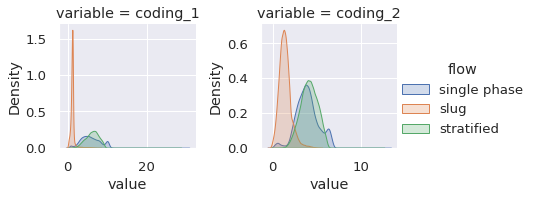

In [89]:
plt.style.use('seaborn')
hue_order = ['slug','stratified' 'single phase']
sns.set(font_scale=1.2)
column=["coding_1", "coding_2"]

df2 = pd.melt(X_codings_train, id_vars='flow', value_vars=column, value_name='value')

hue_order = ['single phase','slug' , 'stratified' ]
g = sns.FacetGrid(df2, col="variable", hue="flow",hue_order=hue_order, sharex=False, sharey=False, col_wrap=2, legend_out=True)
#g.set(xlim=(-6, -0.9))
g.map(sns.kdeplot, "value", fill=True)
g.add_legend()

filename="codings_data_distribution"
if not os.path.exists('figures'):
		os.mkdir('figures')
filename=os.path.join("figures",filename)
    
plt.savefig(filename+'.png',dpi=600, bbox_inches = "tight")  

plt.show()

## Figure 10

Joint distribution of the two encoder features for the different flows. These two features separate single phase and stratified better than any other joint distribution of the original features

The separation between features is more visible when plotting the joint distribution for each flow in a different image

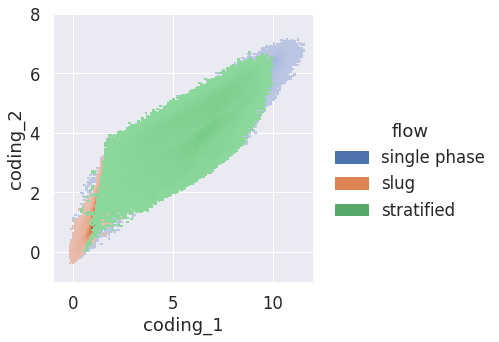

In [93]:
sns.set(font_scale=1.5)

g=sns.displot(data=X_codings_train, x="coding_1", y="coding_2"  , hue="flow",hue_order=hue_order, alpha=1)
g = (g.set_axis_labels("coding_1","coding_2").
set(xlim=(-1,12),ylim=(-1,8)))


filename="codings_joint_distribution"
if not os.path.exists('figures'):
		os.mkdir('figures')
filename=os.path.join("figures",filename)
    
plt.savefig(filename+'.png',dpi=600, bbox_inches = "tight")  

plt.show()

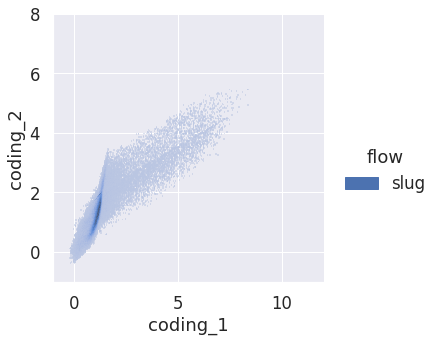

In [96]:
## Joint distribution for stratified
sns.set(font_scale=1.5)

g=sns.displot(data=X_codings_train[X_codings_train["flow"]=="slug"], x="coding_1", y="coding_2"  , hue="flow", alpha=0.5)
g = (g.set_axis_labels("coding_1","coding_2").
set(xlim=(-1,12),ylim=(-1,8)))


filename="PCA_codings_joint_distribution"
if not os.path.exists('figures'):
		os.mkdir('figures')
filename=os.path.join("figures",filename)
    
plt.savefig(filename+'.png',dpi=600, bbox_inches = "tight")  

plt.show()

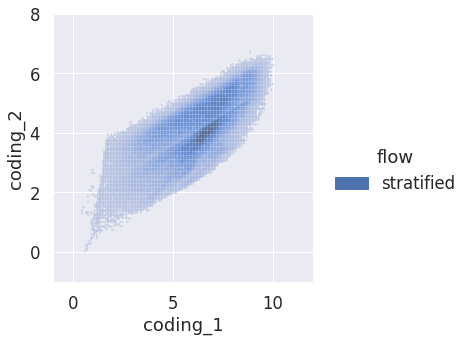

In [94]:
## Joint distribution for stratified
sns.set(font_scale=1.5)

g=sns.displot(data=X_codings_train[X_codings_train["flow"]=="stratified"], x="coding_1", y="coding_2"  , hue="flow", alpha=0.5)
g = (g.set_axis_labels("coding_1","coding_2").
set(xlim=(-1,12),ylim=(-1,8)))


filename="PCA_codings_joint_distribution"
if not os.path.exists('figures'):
		os.mkdir('figures')
filename=os.path.join("figures",filename)
    
plt.savefig(filename+'.png',dpi=600, bbox_inches = "tight")  

plt.show()

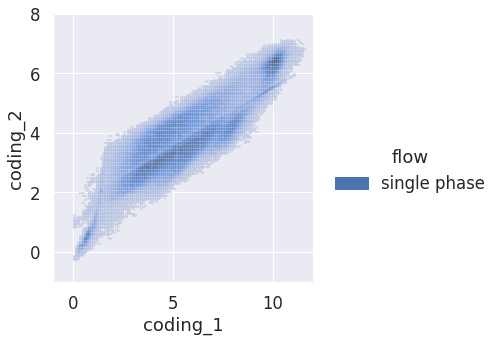

In [95]:
## Joint distribution for single phase
sns.set(font_scale=1.5)

g=sns.displot(data=X_codings_train[X_codings_train["flow"]=="single phase"], x="coding_1", y="coding_2"  , hue="flow", alpha=0.5)
g = (g.set_axis_labels("coding_1","coding_2").
set(xlim=(-1,12),ylim=(-1,8)))


filename="PCA_codings_joint_distribution"
if not os.path.exists('figures'):
		os.mkdir('figures')
filename=os.path.join("figures",filename)
    
plt.savefig(filename+'.png',dpi=600, bbox_inches = "tight")  

plt.show()

# Nex steps

**Denoising autoencoder**
The next step would be to do a denoising autoencoder. In a denoising autoencoder some noise is added to the inputs given to the autoencoder. Then, the autoencoder tries to minimise the distance between the outputs and the inputs (without noise. This method usually can better detect patterns in the data.

**Dropout layers**
Dropout layers can help to decrease overfitting

**Comaprison with other feature reduction alforithms**
Figure 10 shows the joint distribution of the two most importance features extracted with a PCA. The autoencoder has done a slightly better job separating the single phase from the stratified

## PCA
Principal Component Analysis projects the data into the axis with the most variance. It's equivalent to a linear autoencoder

In [ ]:
# adds log of feature1-4
# removes feature 1-4
# Includes depth as a feature
# separates into train and test set
# does StandardScaler() fit on train set and transform on all the data
train_set, test_set, train_labels, test_labels= data_cleaning.prepare_for_LOF("DS_test_DAS_seconds.csv")
x_train=pd.DataFrame.to_numpy(train_set)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [ ]:

pca = PCA(n_components = 2)
X2D = pca.fit_transform(x_train)

In [ ]:
X2D  = pd.DataFrame(
        X2D ,
        dtype=float,
        columns=["coding_1", "coding_2"],
        index=train_set.index)
X2D["flow"]=train_labels

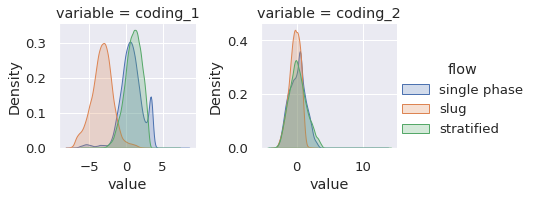

In [ ]:
plt.style.use('seaborn')
sns.set(font_scale=1.2)
column=["coding_1", "coding_2"]
hue_order = ['single phase','slug' , 'stratified' ]
df2 = pd.melt(X2D, id_vars='flow', value_vars=column, value_name='value')
g = sns.FacetGrid(df2, col="variable", hue="flow", hue_order=hue_order, sharex=False, sharey=False, col_wrap=2, legend_out=True)
#g.set(xlim=(-6, -0.9))
g.map(sns.kdeplot, "value", fill=True)
g.add_legend()

filename="PCA_data_distribution"
if not os.path.exists('figures'):
		os.mkdir('figures')
filename=os.path.join("figures",filename)
    
plt.savefig(filename+'.png',dpi=600, bbox_inches = "tight")  

plt.show()

## Figure 11
Joint distribution of the two most important features reduced with a PCA

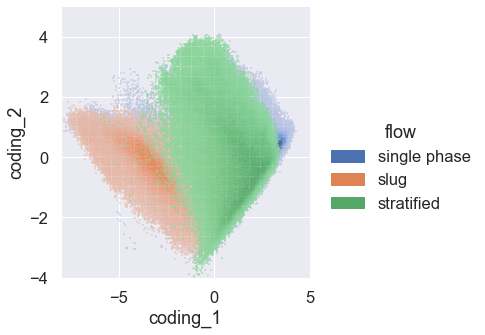

In [ ]:
sns.set(font_scale=1.5)

g=sns.displot(data=X2D, x="coding_1", y="coding_2"  , hue="flow",hue_order=hue_order, alpha=0.5)
g = (g.set_axis_labels("coding_1","coding_2").
set(xlim=(-8,5),ylim=(-4,5)))


filename="PCA_codings_joint_distribution"
if not os.path.exists('figures'):
		os.mkdir('figures')
filename=os.path.join("figures",filename)
    
plt.savefig(filename+'.png',dpi=600, bbox_inches = "tight")  

plt.show()

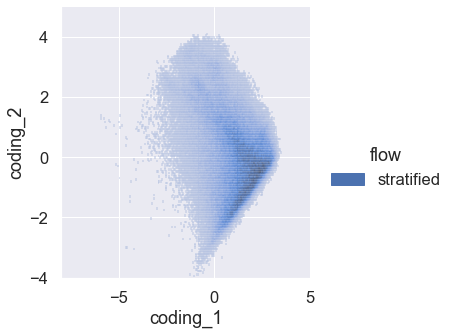

In [ ]:
## joint distribution for only stratified
sns.set(font_scale=1.5)

g=sns.displot(data=X2D[X2D["flow"]=="stratified"], x="coding_1", y="coding_2"  , hue="flow", alpha=0.5)
g = (g.set_axis_labels("coding_1","coding_2").
set(xlim=(-8,5),ylim=(-4,5)))


filename="PCA_codings_joint_distribution"
if not os.path.exists('figures'):
		os.mkdir('figures')
filename=os.path.join("figures",filename)
    
plt.savefig(filename+'.png',dpi=600, bbox_inches = "tight")  

plt.show()

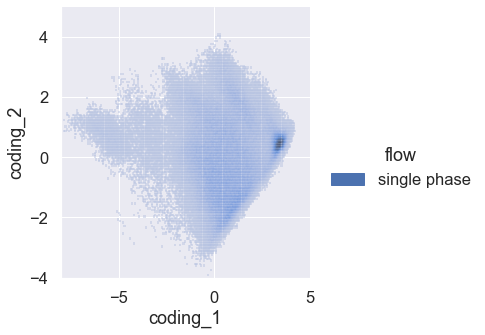

In [ ]:
## joint distribution for only single phase
sns.set(font_scale=1.5)

g=sns.displot(data=X2D[X2D["flow"]=="single phase"], x="coding_1", y="coding_2"  , hue="flow", alpha=0.5)
g = (g.set_axis_labels("coding_1","coding_2").
set(xlim=(-8,5),ylim=(-4,5)))


filename="PCA_codings_joint_distribution"
if not os.path.exists('figures'):
		os.mkdir('figures')
filename=os.path.join("figures",filename)
    
plt.savefig(filename+'.png',dpi=600, bbox_inches = "tight")  

plt.show()